In [1]:
import tensorflow as tf
import numpy as np

In [2]:
HISTORY_TIMES = [3, 7, 15, 31, 47, 63, 95, 127]

PIECES = 256

ADDITIONAL_INPUT_SIZE = 6

In [59]:
tf.reset_default_graph()

# Training Parameters
learning_rate = tf.constant(0.001, dtype=tf.float32)
batch_size = 64
voices = 7
epsilon = 1e-06

# Network Parameters
num_input = 88 + ADDITIONAL_INPUT_SIZE      # dimension of one input at moment
num_hidden_local = 100
num_hidden_read = 100
num_hidden_aggreg = 100
num_output = 88      # output dimension

# tf graph input
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_input])
History = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, len(HISTORY_TIMES), num_output])

with tf.variable_scope("local"):
    local_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_local, forget_bias=1.0)])
    local_lstm_outputs, _ = tf.nn.dynamic_rnn(local_lstm, X[:, :-1], dtype=tf.float32)

with tf.variable_scope("global"):
    read_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_read, forget_bias=1.0)])
    read_lstm_outputs, _ = tf.nn.dynamic_rnn(read_lstm, X[:, :-1], dtype=tf.float32)
read_index = tf.nn.softmax(tf.layers.dense(read_lstm_outputs, len(HISTORY_TIMES), activation=None))
read = tf.reduce_mean(tf.expand_dims(read_index, 3) * History[:, :-1], axis=2)

with tf.variable_scope("aggreg"):
    aggreg_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_aggreg, forget_bias=1.0)])
    aggreg_lstm_outputs, _ = tf.nn.dynamic_rnn(aggreg_lstm, tf.concat([read, local_lstm_outputs], axis=2), dtype=tf.float32)

ans = tf.layers.dense(aggreg_lstm_outputs, (num_output+1)*voices, activation=None)

voices_proba = []
p = tf.zeros([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32)
neg_p = tf.ones([batch_size, tf.shape(X)[1] - 1, (num_output+1)], dtype=tf.float32)
for v in range(voices):
    voices_proba.append(tf.nn.softmax(ans[:, :, v*(num_output+1):(v+1)*(num_output+1)], dim=2))
    p += neg_p * voices_proba[-1]
    neg_p *= (1 - voices_proba[-1])

clip_p = tf.clip_by_value(p[:, :, :-1], epsilon, 1 - epsilon)

ce = -tf.log(clip_p) * X[:, 1:, :num_output] - tf.log(1 - clip_p) * (1 - X[:, 1:, :num_output])
loss_op = tf.reduce_mean(ce)

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

#optimizing
#train_op = tf.contrib.layers.optimize_loss(
#                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [60]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)
saver = tf.train.Saver()

In [61]:
# Run the initializer
sess.run(init)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [7]:
songs = np.load("CM_dataset.npy")

In [8]:
counter = np.ones((ADDITIONAL_INPUT_SIZE))
times = [counter.copy()]
for i in range(10000):
    j = 0
    while j < ADDITIONAL_INPUT_SIZE and counter[j] == 0:
        counter[j] = 1
        j += 1
    if j < ADDITIONAL_INPUT_SIZE:
        counter[j] = 0
    times.append(counter.copy())
times = np.array(times)

In [9]:
def transform(song, stack_zeros=True):    
    wh = song.copy()
    
    hist = []
    for t in HISTORY_TIMES:
        h = np.roll(song, t, axis=0)
        h[:t] = 0
        hist.append(h)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh, np.rollaxis(np.array(hist), 1, 0)

hsongs = []
hhistories = []
for song in songs:
    t, h = transform(song)
    for i in range(0, t.shape[0] - PIECES, 32):
        hsongs.append(t[i:i+PIECES])
        hhistories.append(h[i:i+PIECES])
hsongs = np.array(hsongs)
hhistories = np.array(hhistories)

In [43]:
hhistories.shape

(3874, 256, 8, 88)

In [62]:
saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100-100-100 HistoryUserScheme LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt


0.0158125  mean for last:  0.0143191


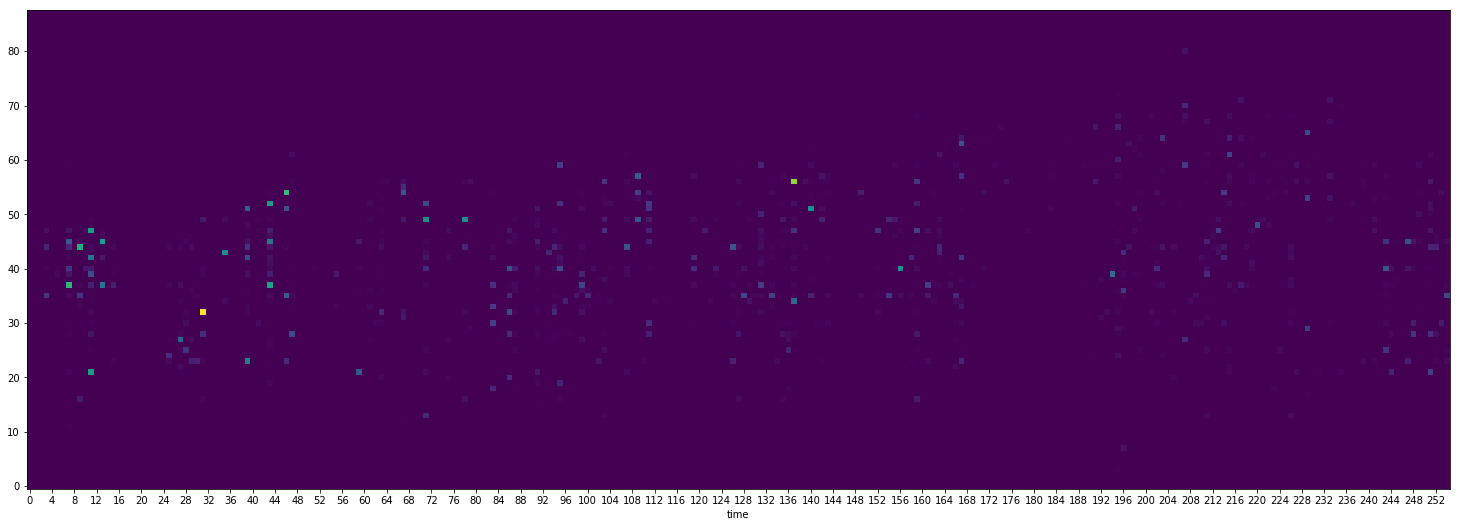

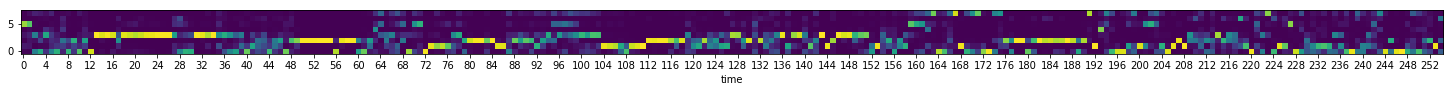

0.0151496  mean for last:  0.0144653


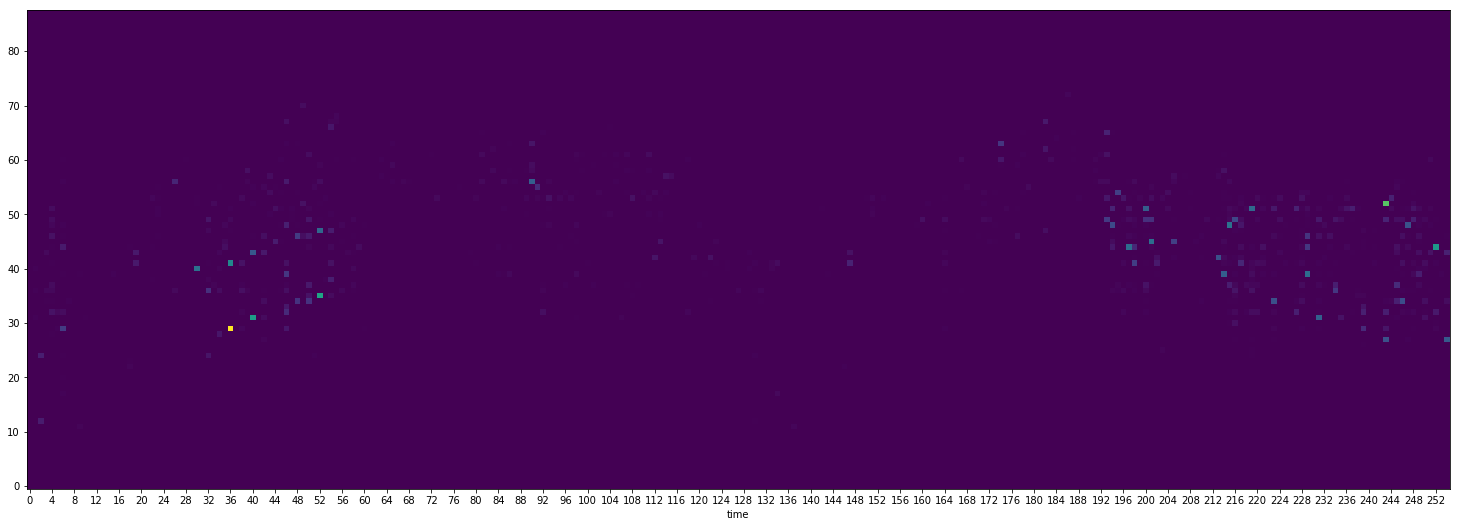

0.0151117  mean for last:  0.0145408


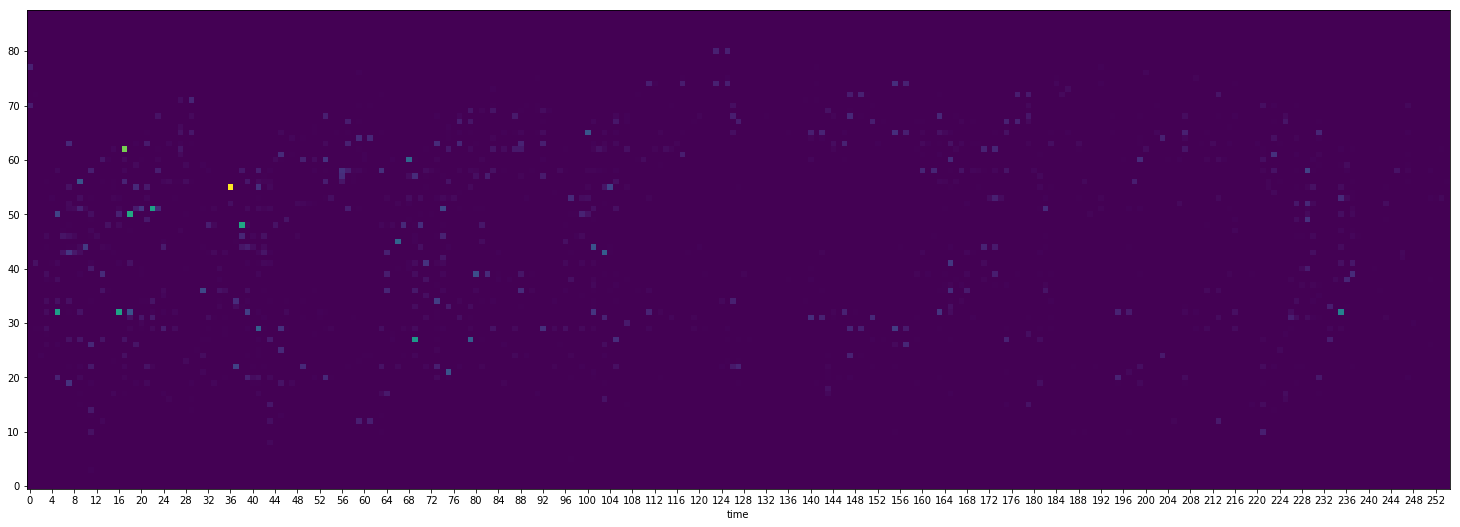

0.0135824  mean for last:  0.0142602


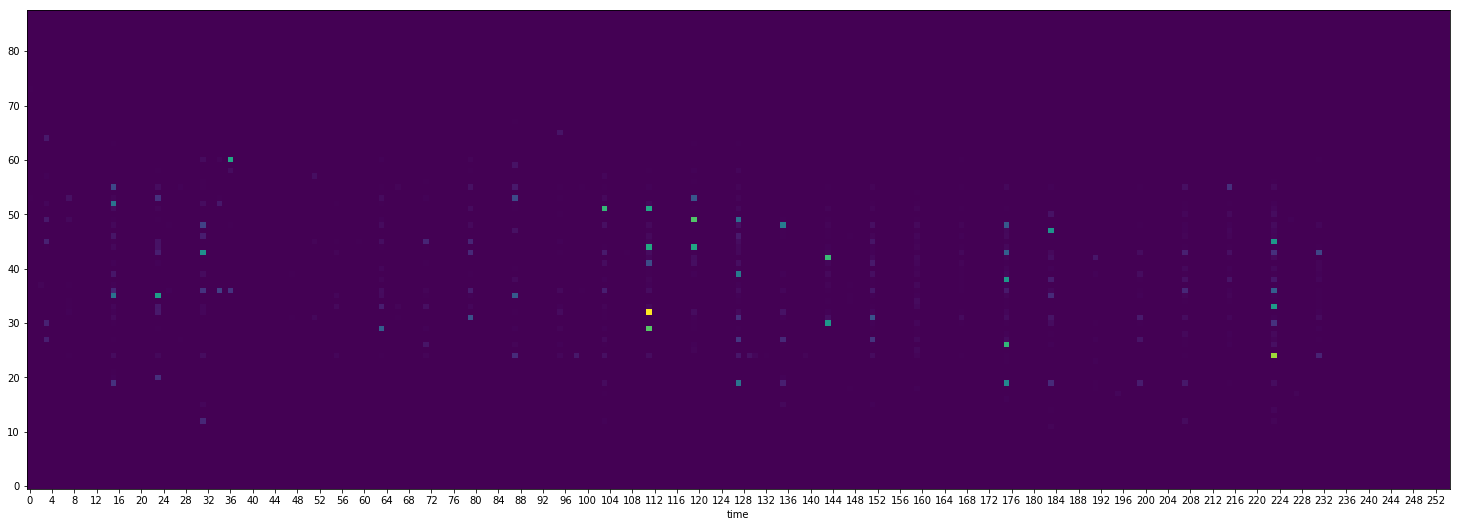

0.0129424  mean for last:  0.0145142


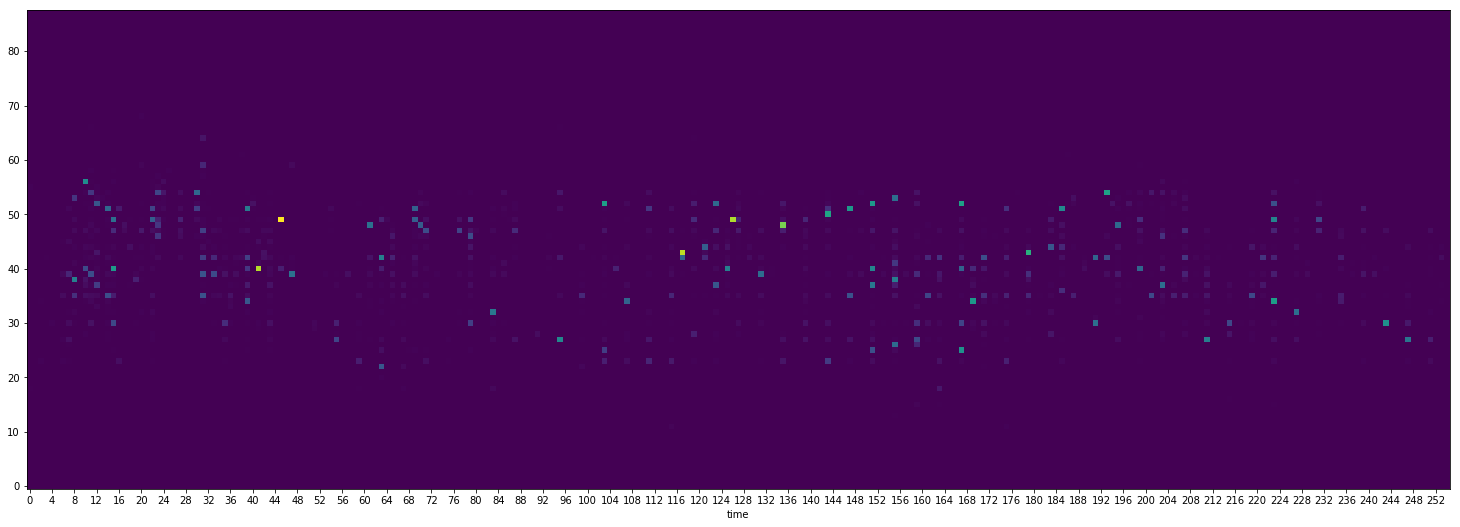

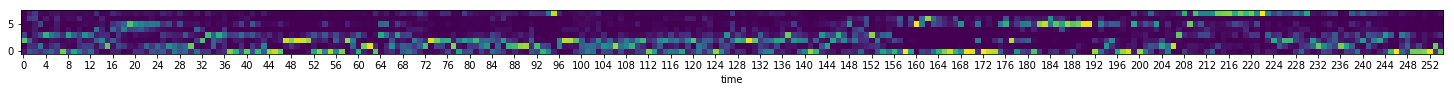

0.0139731  mean for last:  0.0143337


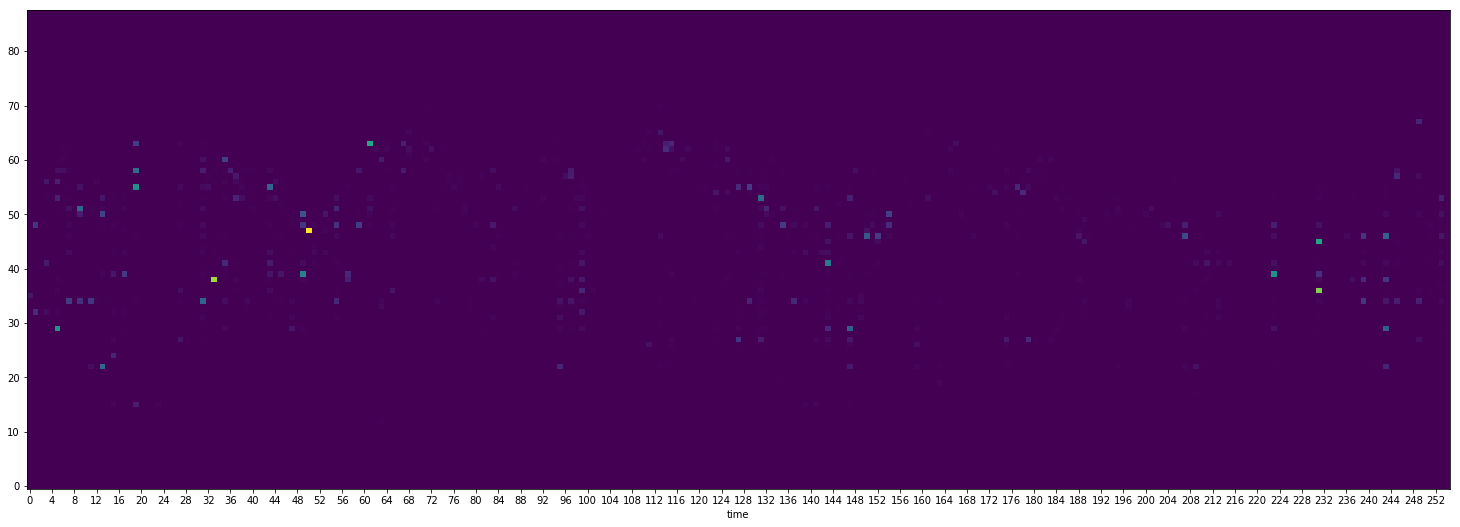

0.0157643  mean for last:  0.0145297


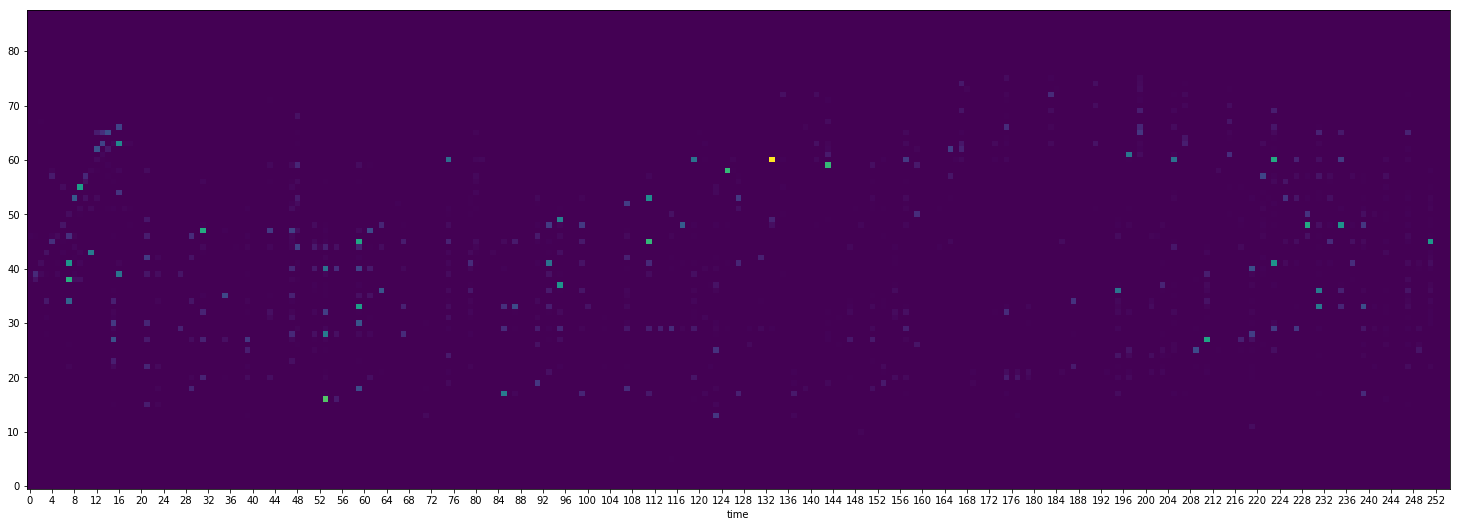

KeyboardInterrupt: 

In [57]:
training_steps = 200000
display_step = 50

#RECORD = 0.0186

#losses = []
for step in range(training_steps + 1):
    # getting data
    indexes = np.random.choice(np.arange(len(hsongs)), batch_size)
    batch_x = hsongs[indexes]
    batch_h = hhistories[indexes]
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x, History: batch_h})
    
    L = sess.run(ce, feed_dict={X: batch_x, History: batch_h})
    losses.append(L.mean())
    
    if np.isnan(L).any():
        print(" DAMN NAN ERROR")
        break
        
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0])
        
        if step % 200 == 0:
            r = sess.run(read_index, feed_dict={X: batch_x, History: batch_h})
            drawNotes(r[0])
           
    if len(losses) > display_step and np.array(losses)[-display_step:].mean() < RECORD:
        RECORD = np.array(losses)[-display_step:].mean()
        saver.save(sess, "./tmp/100-100-100 HistoryUserScheme LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")
      
        
print("Optimization Finished!")

0.014069


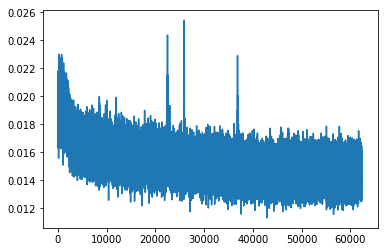

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

print(RECORD)
plt.plot(losses)  #Adam

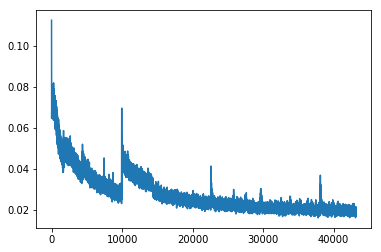

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)  #Adam

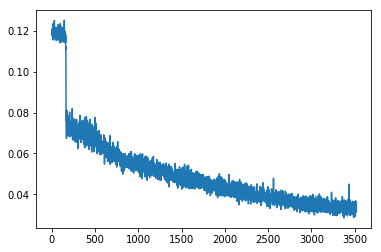

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)  # BackProp или как там его

In [96]:
#np.save("RSSPropLosses.npy", losses)

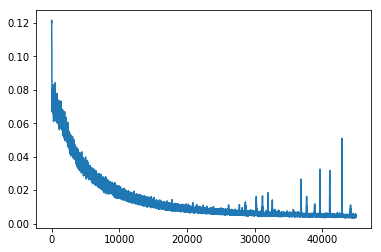

In [13]:
plt.plot(losses)  # 100-100

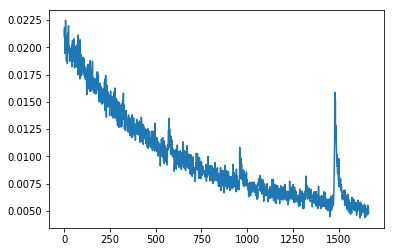

In [11]:
plt.plot(losses)  # one layer, from ~2000 epoch

(0, 0.1)

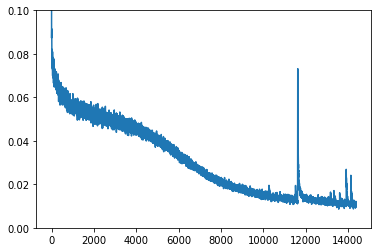

In [38]:
plt.plot(losses)
plt.ylim(0, 0.1)  # no voices mechanizm, one layer

In [47]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat // FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

OSError: MidiOutWinMM::openPort: error creating Windows MM MIDI output port.

In [112]:
saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/100-100-100 HistoryUserScheme LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt


In [63]:
res = []

In [64]:
for s in range(58):
    gen = songs[np.random.randint(0, 100)][:16]

    while len(gen) < 512:
        #saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme LSTM CM_dataset songs by fragments 8-history 6-times 7-voices (one-time) lr=0.01.ckpt")
        #sess.run(train_op, feed_dict=fd)

        gen = np.vstack([gen, np.zeros((88))])

        t, h = transform(gen[-256:])
        fd = {learning_rate: 0, X: np.repeat(t[None], batch_size, axis=0), History: np.repeat(h[None], batch_size, axis=0)}
        probas = sess.run(voices_proba, feed_dict=fd)

        for i in range(voices):
            note = np.random.choice(range(89), p=probas[i][0, -1])
            if note != 88:
                gen[-1, note] = 1

        print('|', end="")
    print("yeah!", i)
    res.append(gen)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 6
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 6
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 6
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 6
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

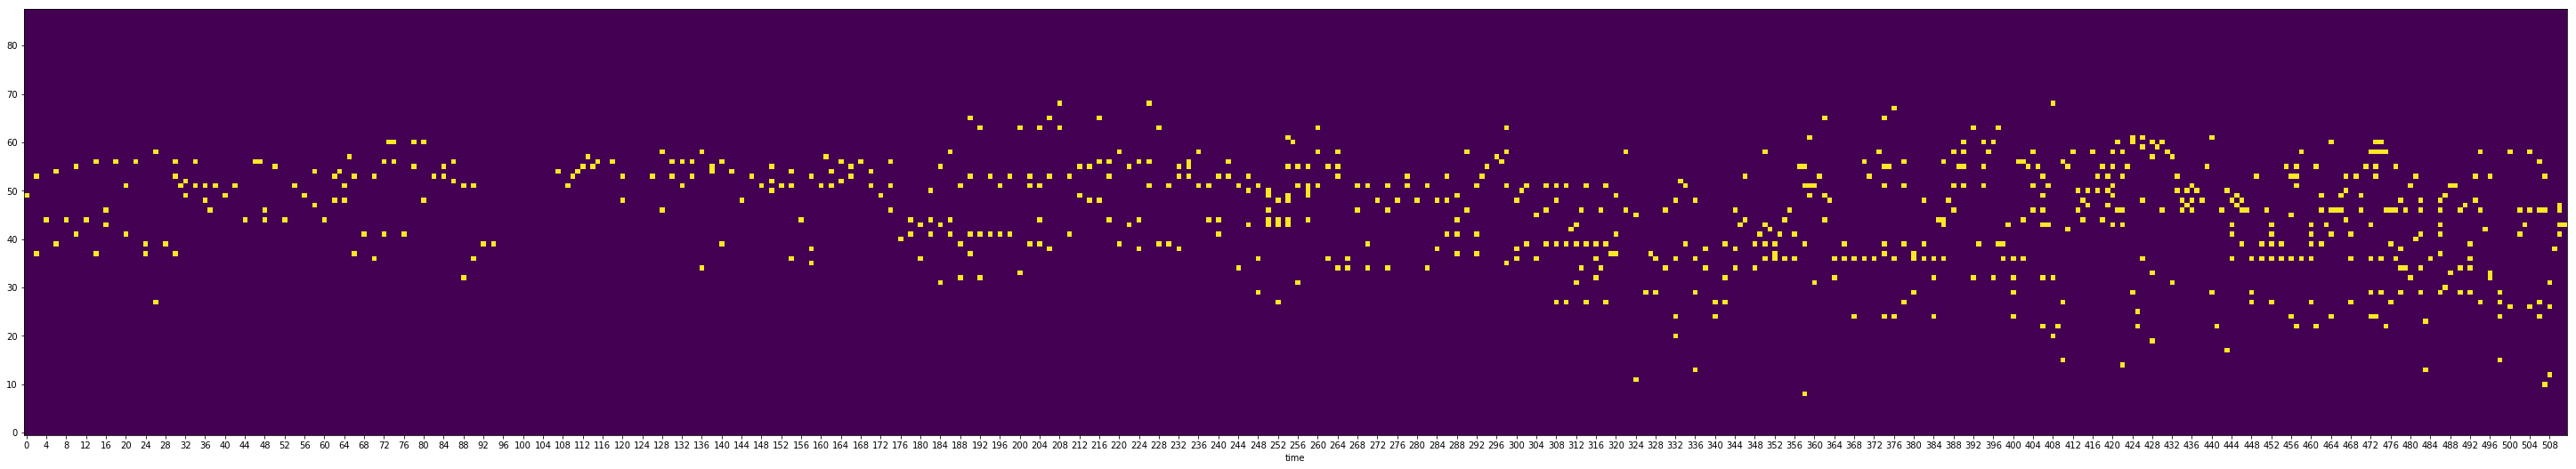

In [65]:
drawNotes(res[0])

In [66]:
ms = MySong(res[0], finished=True)

In [67]:
ms.play()

In [68]:
finale = np.zeros((0, 88))
for r in res:
    finale = np.vstack([finale, np.zeros((8, 88))])
    finale = np.vstack([finale, r[16:]])

In [69]:
finale.shape

(29232, 88)

In [70]:
finale = finale[:28760]

In [71]:
ms = MySong(finale, finished=True)

In [72]:
ms.save_file("2 Submit. 100-100-100 HistoryUser CM_dataset loss=0.14")